In [23]:
# %%
# Import necessary libraries
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

# Define ImageNet statistics for normalization
mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
std = np.array([58.393, 57.12, 57.375], dtype=np.float32)


In [24]:
# %%
# Define directory paths and file names
image_folder = '102flowers'      # Folder containing the flower images
segmentation_folder = '102segmentations'  # Folder containing segmentation masks
label_file = 'imagelabels.mat'   # File containing image labels
setid_file = 'setid.mat'         # File containing data splits


In [25]:
# %%
# Load image labels from imagelabels.mat
label_data = loadmat(label_file)
labels = label_data['labels'][0]
setid_data = loadmat(setid_file)
train_ids = setid_data['trnid'][0] - 1
val_ids = setid_data['valid'][0] - 1
test_ids = setid_data['tstid'][0] - 1
class_labels = np.unique(labels)  # Define class labels based on unique labels from the dataset


In [32]:
def adjust_dynamic_range(image):
    """ Apply random brightness and contrast. """
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast
    return image


def preprocess_function(image):
    """ Normalize images as per ImageNet standards. """
    mean = np.array([123.68, 116.779, 103.939])
    std = np.array([58.393, 57.12, 57.375])
    image = (image - mean) / std  # Normalize the image
    return image


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: preprocess_function(adjust_dynamic_range(x))  # Adjust first, then normalize
)


In [27]:
# %%
# Function to preprocess images
def preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = img_to_array(image)
    return preprocess_function(image)

def load_and_preprocess_images(image_folder, image_ids, labels, target_size):
    images, image_labels = [], []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f'image_{image_id + 1:05d}.jpg')
        if os.path.exists(image_path):
            images.append(preprocess_image(image_path, target_size))
            image_labels.append(labels[image_id])
        else:
            print(f"Image file not found: {image_path}")
    return np.array(images), np.array(image_labels)

train_images, train_labels = load_and_preprocess_images(image_folder, train_ids, labels, (224, 224))
val_images, val_labels = load_and_preprocess_images(image_folder, val_ids, labels, (224, 224))
test_images, test_labels = load_and_preprocess_images(image_folder, test_ids, labels, (224, 224))


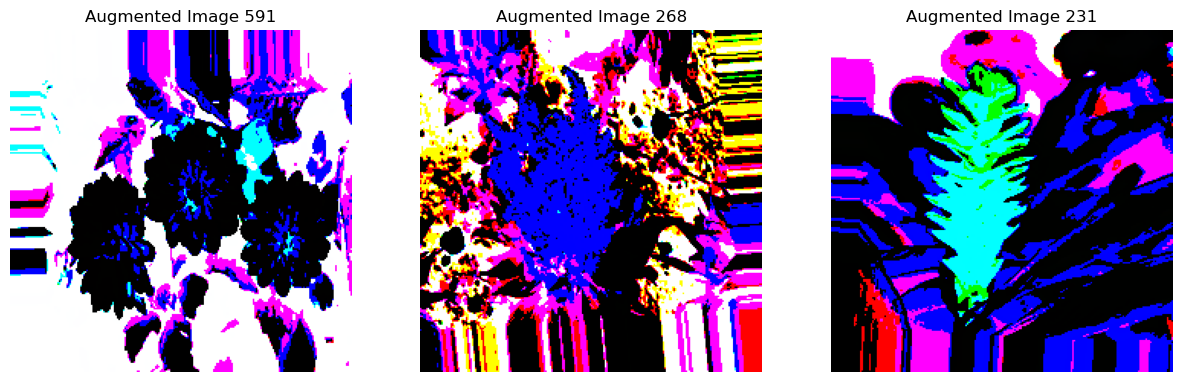

In [33]:
# %%
# Import necessary libraries for random selection
import random

# Select three random images from the training set
indices = random.sample(range(len(train_images)), 3)  # Generate three unique random indices

# Create a new figure with larger size for better visibility
plt.figure(figsize=(15, 5))

# Visualization code block
for j, idx in enumerate(indices):
    sample_image = train_images[idx]
    sample_image = np.expand_dims(sample_image, axis=0)  # Prepare for augmentation
    augmented_images = datagen.flow(sample_image, batch_size=1)
    
    plt.subplot(1, 3, j + 1)
    image = next(augmented_images)[0]
    image_display = (image * std + mean).astype(np.uint8)  # Reverse normalization for display
    plt.imshow(image_display)
    plt.title(f"Augmented Image {idx+1}")
    plt.axis('off')
plt.show()



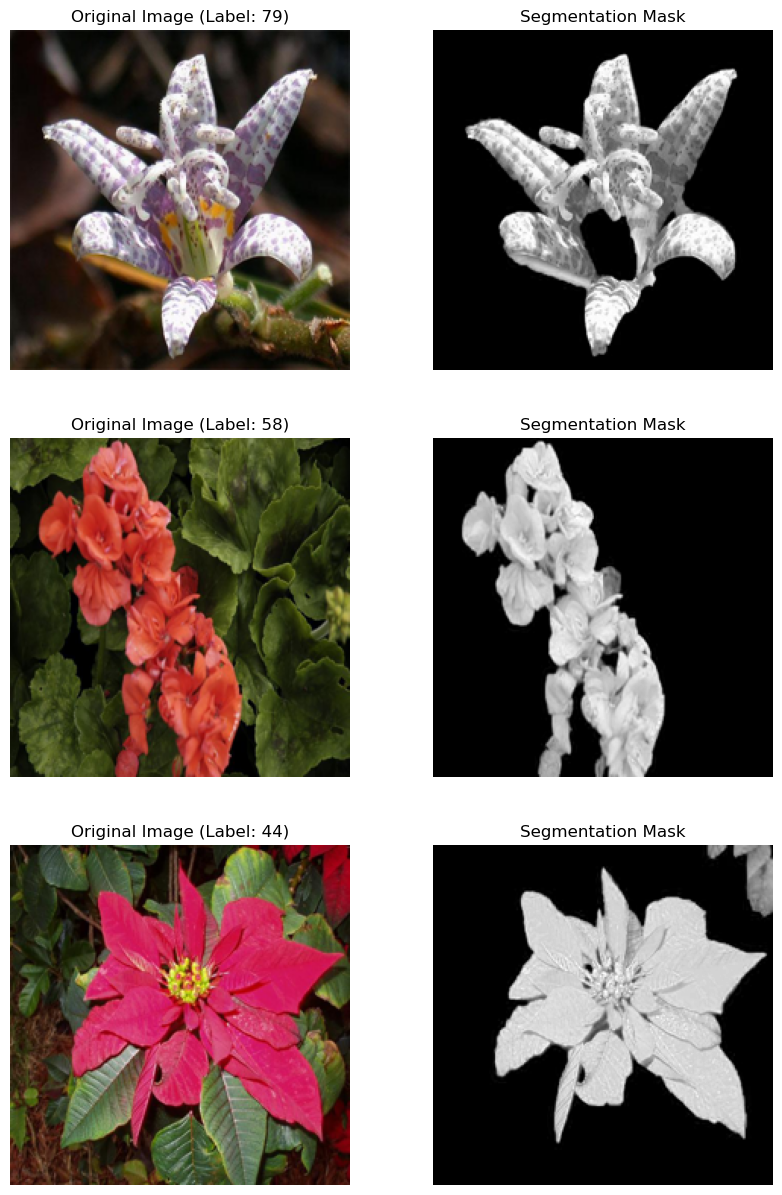

In [35]:
# %%
# Function to load and preprocess segmentation masks
def load_and_preprocess_segmentation_masks(segmentation_folder, image_ids, target_size):
    segmentations = []
    for image_id in image_ids:
        segmentation_path = os.path.join(segmentation_folder, f'segmim_{image_id + 1:05d}.jpg')
        if os.path.exists(segmentation_path):
            segmentation = Image.open(segmentation_path)
            segmentation = segmentation.resize(target_size)
            segmentation = img_to_array(segmentation) / 255.0
            segmentations.append(segmentation)
        else:
            print(f"Segmentation mask file not found: {segmentation_path}")
            segmentations.append(np.zeros((target_size[0], target_size[1], 1)))
    return np.array(segmentations)

train_segmentations = load_and_preprocess_segmentation_masks(segmentation_folder, train_ids, (224, 224))

# %%
# Visualize random segmentation examples
def visualize_random_segmentation_examples(images, segmentations, labels, num_examples=3):
    indices = np.random.choice(len(images), num_examples, replace=False)
    plt.figure(figsize=(10, 5 * num_examples))
    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow((images[idx] * std + mean).astype(np.uint8))  # Scale back for display
        plt.title(f'Original Image (Label: {labels[idx]})')
        plt.axis('off')

        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(segmentations[idx][:, :, 0], cmap='gray')  # Assuming segmentation is single-channel
        plt.title('Segmentation Mask')
        plt.axis('off')
    plt.show()

visualize_random_segmentation_examples(train_images, train_segmentations, train_labels)
